<div style="font-size:1.4em; margin-bottom:2em">
    <div style="float:right; line-height:1.2em;">GET Lab<br />Paderborn University</div>
  <div>SS 2021</div>
</div>
<div style="clear:both"></div>
<div style="text-align:center; font-size:1.8em;">
  Digital Image Processing II<br />Task Sheet 11
</div>

<hr>

### Overview

The objective of this task sheet is to implement a Bayes classifier for segmenting a multispectral image. Each pixel should be classified as either *urban*, *vegetation*, or *water*. The image consists of four channels (single images), where each channel represents one band: *red*, *green*, *blue*, and *infrared*. For the implementation, we assume Gaussian distributions (probability density functions) for the likelihoods $p(\mathbf{x}|w_i)$.

The following figure shows the individual channels (a = *red*, b = *green*, c = *blue*, d = *infrared*) as well as binary masks, which are used to provide training data (e = *urban*, f = *vegetation*, g = *water*):

<center><img src="images/images-overview.png" width="800px" style="margin:10px;" /></center>

The decision function of the Bayes classifier is given as follows:

$$d_i(\textbf{x})=p(\mathbf{x}|w_i)P(w_i)$$

In this equation, the likelihood $p(\mathbf{x}|w_i)$ describes the distribution of the feature vectors of the training examples and $P(w_i)$ is the prior probability of each class. For $n$-dimensional feature vectors, the corresponding Gaussian has the following form:

$$
p(\mathbf{x}|w_i)
= \dfrac{1}{\sqrt{(2\pi)^n |\mathbf{C}_i|}} \exp\left(-\frac{1}{2}(\mathbf{x}-\mathbf{m}_i)^T\mathbf{C}_j^{-1}(\mathbf{x}-\mathbf{m}_i)\right)
$$

In this equation, $\mathbf{m}_i$ is the mean vector and $\mathbf{C}_i$ the covariance matrix of the class.

---

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

dpi = plt.rcParams['figure.dpi']

# plot image in original size
def plot_img_orig(img):
    fig = plt.figure(figsize = (img.shape[1]/dpi, img.shape[0]/dpi))
    fig.add_axes([0, 0, 1, 1])
    plt.axis('off')
    plt.imshow(img, cmap='gray', vmin=0, vmax=255) # cmap parameter is ignored for RGB(A) data
    plt.show()

#### <span style="color: RoyalBlue; font-weight: bold;">Task 11.1</span> Feature Extraction

In the first step, the feature vectors of the training examples (each pixel of the corresponding masks) should be extracted and plotted in the feature space. As the feature vectors are four-dimensional so that $\mathbf{x} = [x_1, x_2, x_3, x_4]^T$, they cannot be plotted directly. One option is to plot 2D combinations of features, such as $x_1$ together with $x_2$, $x_1$ together with $x_3$, and so on. This should give an impression on the distribution and separation of the classes and if less than four features are sufficient for a reliable classification.

Implement / solve the following tasks:
1. Extract the training feature vectors based on the masks and use appropriate data structures to store the results.
2. Plot all combinations of the features in 2D sub-spaces of the feature space.
3. Which features should be used if the classification should be based on only two features?

x1 and x2:


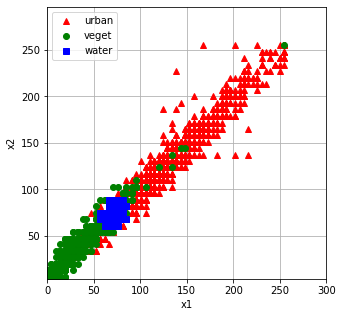

x1 and x3:


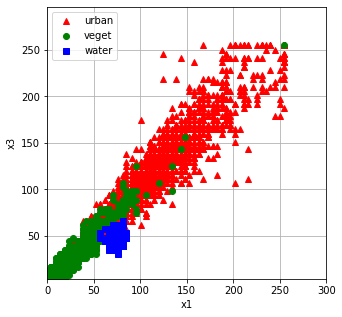

x2 and x3:


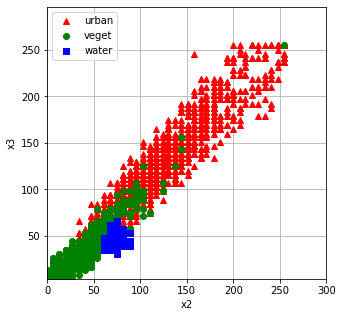

x1 and x4:


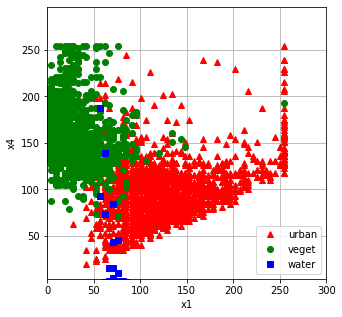

x2 and x4:


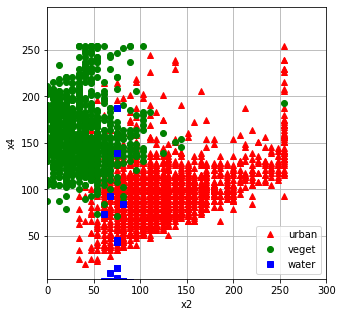

x3 and x4:


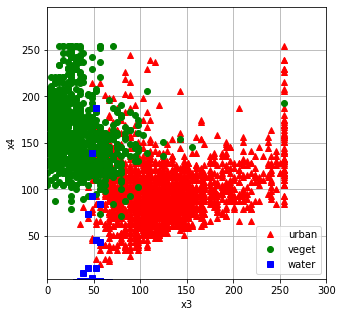

In [2]:
# write your code here

# read channel images as grayscale images (parameter 0)
img_r = cv2.imread('images/washington-red.png', 0)
img_g = cv2.imread('images/washington-green.png', 0)
img_b = cv2.imread('images/washington-blue.png', 0)
img_i = cv2.imread('images/washington-infrared.png', 0)

# read masks as grayscale images (parameter 0)
mask_urban = cv2.imread('images/mask-urban.png', 0)
mask_veget = cv2.imread('images/mask-vegetation.png', 0)
mask_water = cv2.imread('images/mask-water.png', 0)

# stack the images on top of each other (each image is one plane of the stack)
data = np.stack([img_r, img_g, img_b, img_i])

# get the training feature vectors
# each column represents one set of [x1, x2, x3, x4]
urban = data[:, mask_urban > 0]
veget = data[:, mask_veget > 0]
water = data[:, mask_water > 0]
            
# plot different feature combinations in the feature space
for k in range(4):
    for l in range(k): # using x1 and x2 is the same as using x2 and x1
        label1 = "x" + str(l+1) # first feature index is 1, therefore k+1
        label2 = "x" + str(k+1)
        
        print(label1 + " and " + label2 + ":")

        plt.figure(figsize=(5, 5))

        plt.plot(urban[l,:], urban[k,:], 'r^', label='urban')
        plt.plot(veget[l,:], veget[k,:], 'go', label='veget')
        plt.plot(water[l,:], water[k,:], 'bs', label='water')

        plt.xlabel(label1); plt.ylabel(label2)
        plt.axis("equal")
        plt.xlim(0, 300); plt.ylim(0, 300)

        plt.grid()
        plt.legend()
        plt.show()

For a classification based on two features, using the red and green ($x_1$ and $x_2$) or the green and blue ($x_2$ and $x_3$) channels seem to be a good choice because the feature vectors are forming connected clusters with elliptical shapes. Such distributions can be represented quite accurately with Gaussians.

#### <span style="color: RoyalBlue; font-weight: bold;">Task 11.2</span> Bayes Classifier

In the decision function from the overview, the likelihood $p(\mathbf{x}|w_i)$ and the prior $P(w_i)$ have to be estimated or known for each class. In this example, it can be assumed that each class has the same prior so that $P(w_i) = 1/3$. This just means that it is assumed that each class is equally likely to appear at any pixel. Based on the training data, we can compute an estimate for $p(\mathbf{x}|w_i)$ by computing the corresponding mean vectors $\mathbf{m}_i$ and covariance matrices $\mathbf{C}_i$. Next, they can be substituted in the standard formula of the Gaussian (see overview), which is not very handy due to the square root and exponential form.

Because the (natural) logarithm is a monotonically increasing function, we can use it to simplify the decision function without affecting the numerical order for different classes. This simplification leads to the following decision function:

$$d_i(\mathbf{x})=\ln P(w_i)-\displaystyle\frac{1}{2}\ln|\mathbf{C}_i|-\displaystyle\frac{1}{2}\left[(\mathbf{x}-\mathbf{m}_i)^T \mathbf{C}_i^{-1}(\mathbf{x}-\mathbf{m}_i)\right]$$

Implement / solve the following tasks:
1. Compute the mean vector $\mathbf{m}_i$ and covariance matrix $\mathbf{C}_i$ for each class based on the training examples (masks).
2. Implement a function to compute the value of the decision function based on the given template.
3. Classify each pixel and plot the results using different colors (*urban* = red, *vegetation* = green, *water* = blue).

cov_urban =
[[2111.4435979  2081.2053464  1987.37700267  428.96667376]
 [2081.2053464  2149.66856827 2051.59738807  489.83440955]
 [1987.37700267 2051.59738807 2172.86237444  323.9451501 ]
 [ 428.96667376  489.83440955  323.9451501   940.46936048]]
cov_veget =
[[ 587.55002472  584.57829532  562.71616    -173.47850601]
 [ 584.57829532  635.43520091  572.78378088  -34.55559736]
 [ 562.71616     572.78378088  593.61451637 -188.55624772]
 [-173.47850601  -34.55559736 -188.55624772 1174.74569475]]
cov_water =
[[ 2.00360852e+01  5.13412167e+00  4.86646926e+00 -6.97616371e+00]
 [ 5.13412167e+00  2.11539050e+01  5.51816465e+00  1.90563973e-02]
 [ 4.86646926e+00  5.51816465e+00  2.78053295e+01  2.64397370e+00]
 [-6.97616371e+00  1.90563973e-02  2.64397370e+00  8.27209529e+01]]


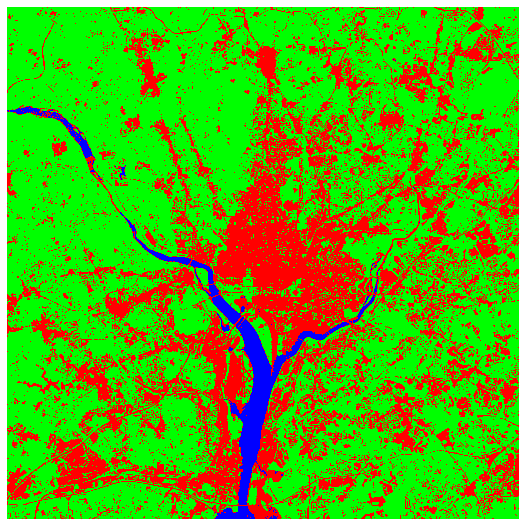

In [3]:
# write your code here

# compute the corresponding mean vectors
mean_urban = np.mean(urban, axis=1)
mean_veget = np.mean(veget, axis=1)
mean_water = np.mean(water, axis=1)

# compute the corresponding covariance matrices
# each column represents one feature vector (one observation)
# see https://numpy.org/doc/stable/reference/generated/numpy.cov.html
cov_urban = np.cov(urban)
cov_veget = np.cov(veget)
cov_water = np.cov(water)

# print the covariance matrices
print("cov_urban ="); print(cov_urban)
print("cov_veget ="); print(cov_veget)
print("cov_water ="); print(cov_water)

# for each pixel from the input image, compute the value of the decision function
# x = feature vector, prior = P(w_i), mean = mean vector, cov = covariance matrix
def getDecisionFunctionValue(x, prior, mean, cov):
    detCov = np.linalg.det(cov) # determinant of the covariance matrix
    invCov = np.linalg.inv(cov) # inverse of the covariance matrix
    
    # right part of the decision function
    diff = x-mean
    bracket = np.dot(np.dot(np.transpose(diff), invCov), diff)
    
    # compute and return the final result
    res = np.log(prior)-0.5*np.log(detCov)-0.5*bracket
    return res
    
# empty RGB image to save and display the classification result
rows, cols = img_r.shape
result = np.zeros((rows, cols, 3), dtype=np.uint8)

for i in range(rows):
    for j in range(cols):
        # get x1 and x2 for the current pixel
        x = [img_r[i, j], img_g[i, j], img_b[i, j], img_i[i, j]]
        
        # compute the values of the decision functions
        d_urban = getDecisionFunctionValue(x, 1/3, mean_urban, cov_urban)
        d_veget = getDecisionFunctionValue(x, 1/3, mean_veget, cov_veget)
        d_water = getDecisionFunctionValue(x, 1/3, mean_water, cov_water)
        
        # decide for the class with the highest value
        if (d_urban > d_water) and (d_urban > d_veget): # urban (red)
            result[i, j] = [255, 0, 0]
        elif (d_water > d_urban) and (d_water > d_veget): # water (blue)
            result[i, j] = [0, 0, 255]
        elif (d_veget > d_urban) and (d_veget > d_water): # vegetation (green)
            result[i, j] = [0, 255, 0]
        else:
            print("classification error")
            
# plot the final result
plot_img_orig(result)